# Notebook to demonstrate:

## 1. population model being optimized with gradient descent

## 2. population model forecasting hospital-admissions 

In [1]:
import datetime
import turicreate as tc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

%load_ext autoreload
%autoreload 2

from PopulationData import PopulationData
from HospitalData import HospitalData

from PopulationModel import PopulationModel


# Inspect the ground-truth data of hospital-admissions that we retrieve from the Health Human Services (HHS) website

### - we define that we want to retrieve data from lookback_date until '20210601' via the HospitalData.py object

### - we will train our model to forecast for the past time period of training_start_date to training_end_date (green shaded in plot)

<ipython-input-2-13a381989187>:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);


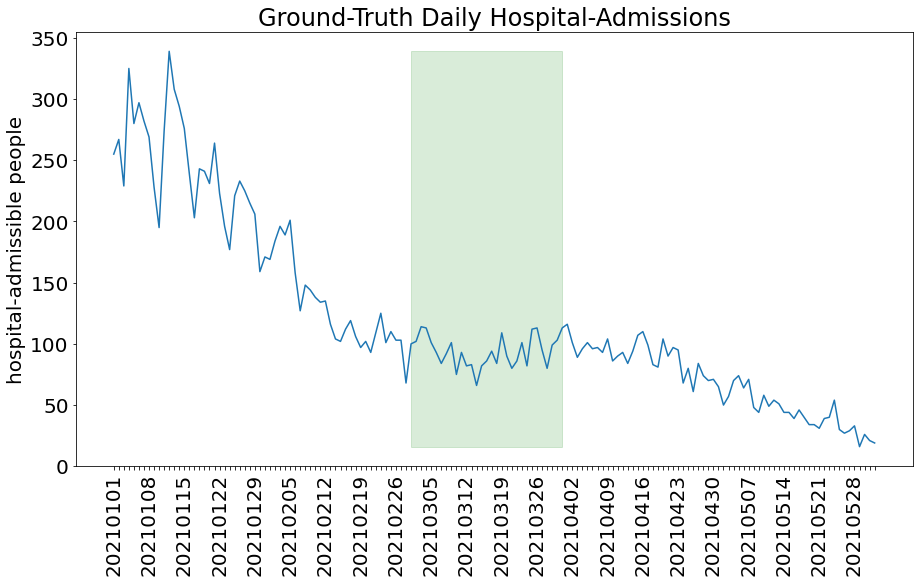

In [2]:
# covidestim_csv = 'covidestim.csv'
state_long = 'Massachusetts'
state_short = 'MA' 

# state_long = 'Minnesota'
# state_short = 'MN' 

results_folder = 'results/'
data_folder = 'data/'

# training_start_date = '20210101'
# training_end_date = '20210401' 

training_start_date = '20210301'
training_end_date = '20210401' 


# ground truth data from a lookback_date to '20210601' to guide model's predictions toward a good fit
lookback_date = '20210101'
hd_truthful = HospitalData('HHS_data_selective.csv', state_short,lookback_date,'20210601')
truthful_Admission_counts = hd_truthful.get_Admission_counts()
plt.figure(figsize=(15,8))    
plt.plot(truthful_Admission_counts);

date_xlabels = [d if i%7 == 0 else '' for i,d in enumerate(hd_truthful.filtered_data['date']) ]
plt.xticks(range(len(date_xlabels)), labels=date_xlabels, Rotation=90);
plt.title('Ground-Truth Daily Hospital-Admissions')
plt.ylabel('hospital-admissible people')
training_end_date_idx = list(hd_truthful.filtered_data['date']).index(training_end_date)
training_start_date_idx = list(hd_truthful.filtered_data['date']).index(training_start_date)
plt.fill_between(range(training_start_date_idx,training_end_date_idx), min(truthful_Admission_counts), max(truthful_Admission_counts),alpha=0.15, color='green')

plt.show()


# Defining the model with the warmup dataset from covidestim.org

covidestim.org data from lookback_date to the training_start_date will be used to warm up the model 

In other words at timepoint t=training_start_date, initial starting approximate values for the states I,S,A,H are calculated from covidestim.org data

In [3]:

# getting data from covidestim.org
pd_warmup_data = PopulationData(data_folder+"covidestim.csv", state_long,lookback_date, training_start_date);
pop_model = PopulationModel(warmup_data_obj=pd_warmup_data)

print(pop_model.warmup_data.filtered_data)


+---------------+----------+--------------------+--------------------+
|     state     |   date   |         Rt         |     infections     |
+---------------+----------+--------------------+--------------------+
| Massachusetts | 20210101 | 0.9776011848439728 | 14972.199238313651 |
| Massachusetts | 20210102 | 0.9702972207669376 | 14880.774724577155 |
| Massachusetts | 20210103 | 0.9631869545633196 | 14767.848596215084 |
| Massachusetts | 20210104 | 0.9563796197877016 | 14634.698315093352 |
| Massachusetts | 20210105 | 0.9499812496520746 | 14483.003765333677 |
| Massachusetts | 20210106 | 0.9440857331484576 | 14314.783483619432 |
| Massachusetts | 20210107 | 0.9387199361038372 | 14132.15820212688  |
| Massachusetts | 20210108 | 0.933882690426855  | 13937.239574355068 |
| Massachusetts | 20210109 | 0.9295730397468848 | 13732.109752275996 |
| Massachusetts | 20210110 | 0.925790374119108  | 13518.803872116492 |
+---------------+----------+--------------------+--------------------+
+-----

# Fit the model to a given training dataset from HHS hospital admissions

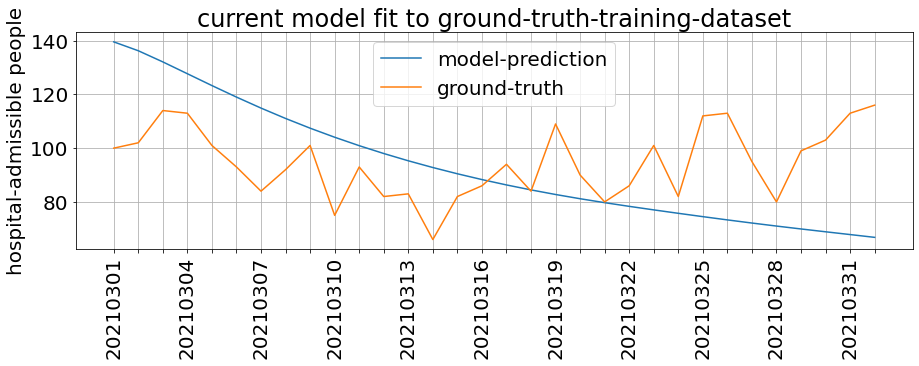

----------------------Iter  0 ----------------------
230.1366428235017 loss at iteration 
-167.69557176140017 symptomatic gradient at iteration 


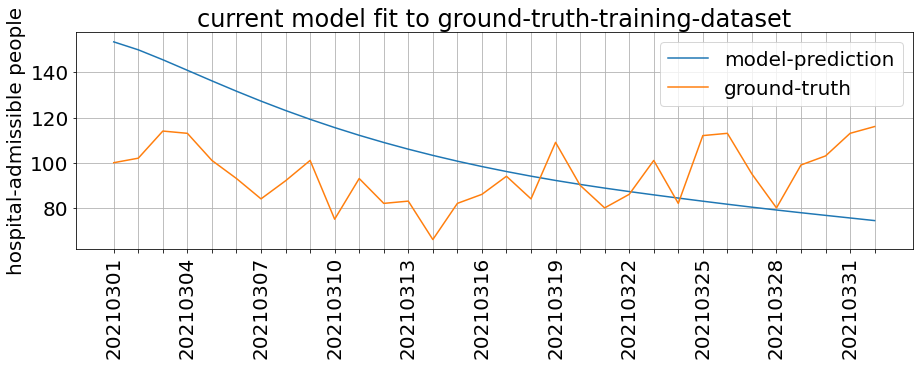

----------------------Iter  5 ----------------------
196.64303814349677 loss at iteration 
-81.6448307888021 symptomatic gradient at iteration 


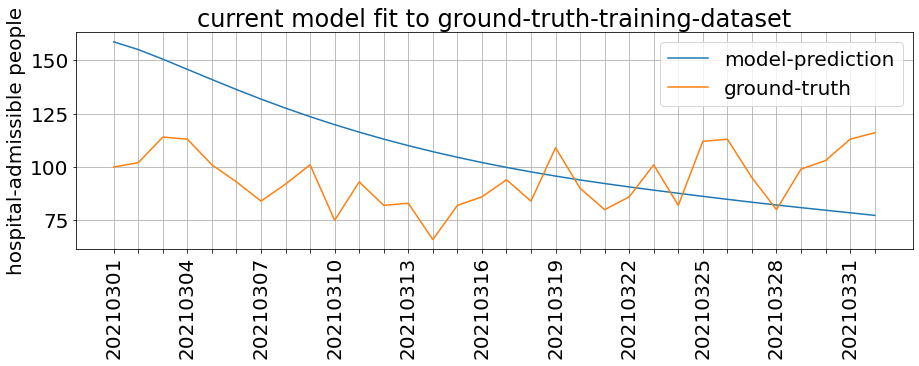

----------------------Iter  10 ----------------------
191.82788194669456 loss at iteration 
-49.32181523278395 symptomatic gradient at iteration 


In [4]:
training_data_obj = HospitalData('HHS_data_selective.csv', state_short, start_date=training_start_date,end_date=training_end_date)
pop_model.fit(training_data_obj, 
              n_iters=12, step_size_txn=5e-5, step_size_soj=9e-5, n_steps_between_print=5, lambda_reg=1e-3,epsilon_stop=1e-4, plots=True)

# See how gradient descent did in terms of reducing the loss function over each iteration

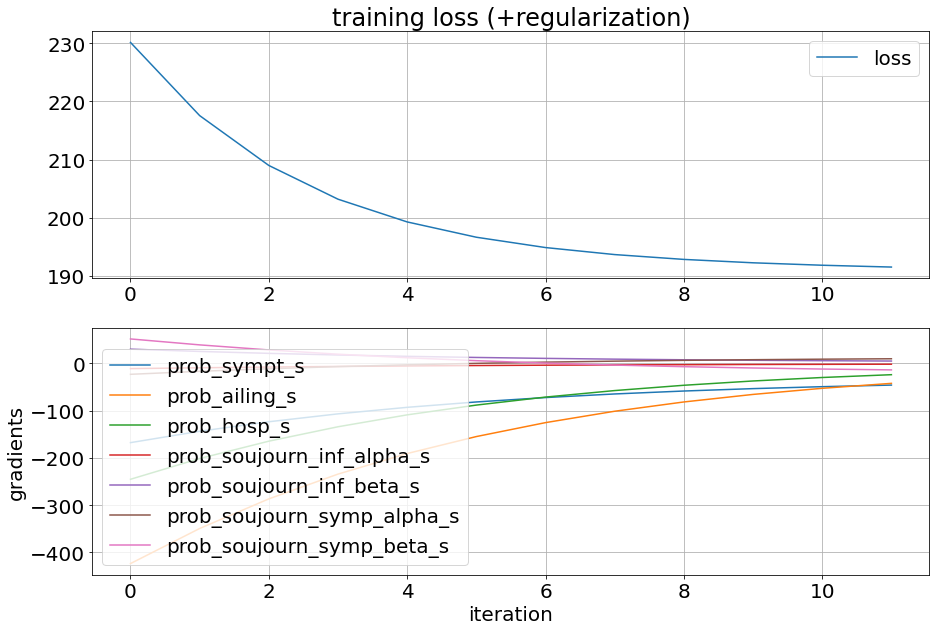

In [5]:
fig, [train_ax1, train_ax2] = plt.subplots(nrows=2, ncols=1,figsize=(15,10))    

train_ax1.plot(pop_model.loss_per_iter, label='loss')
train_ax1.set_title('training loss (+regularization)')
train_ax1.legend()
train_ax1.grid()

for k,v in pop_model.gradients_per_iter.items():
    if k in ['prob_sympt_s',
                'prob_ailing_s',
                'prob_hosp_s',
                'prob_soujourn_inf_alpha_s',
                'prob_soujourn_inf_beta_s',
                'prob_soujourn_symp_alpha_s',
                'prob_soujourn_symp_beta_s']:
        train_ax2.plot(v,label=k)

train_ax2.legend()
train_ax2.grid()
train_ax2.set_ylabel('gradients')
train_ax2.set_xlabel('iteration')
plt.show()


# Use the optimized/learned pop_model.params to forecast beyond the training dates

setting save_admissions = True will generate forecasted_admissions.csv

{'T_serial': 5.807579092688291, 'Rt_shift': 0.2, 'days_of_imposed_restrictions': [], 'days_of_relaxed_restrictions': [], 'prob_sympt_s': 0.6697726061933547, 'prob_ailing_s': -2.8411416959316074, 'prob_hosp_s': -0.14143112185729576, 'prob_soujourn_inf_alpha_s': 3.3817346895914513, 'prob_soujourn_inf_beta_s': -0.19927900707582033, 'prob_soujourn_symp_alpha_s': 1.4022787716574767, 'prob_soujourn_symp_beta_s': -1.4234560490920611}

 ***forecasted hospital-admissible numbers saved to  results/forecasted_admissions.csv


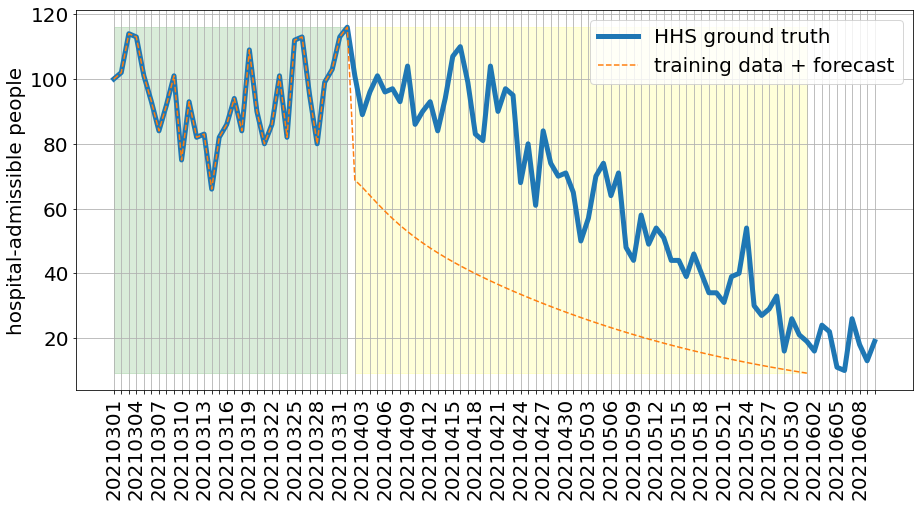

In [6]:
pop_model.training_mode=False
pop_model.warmup_data.end_date = training_end_date
pop_model.forecast_duration=60

print(pop_model.params)
plt.figure(figsize = (15,7))


training_hospitalizations = list(training_data_obj.get_Admission_counts())
forecasted_hospitalizations = list(pop_model.get_forecasted_data(save_admissions=True)['hospitalized']) 
training_forecasted_hospitalizations = training_hospitalizations + forecasted_hospitalizations
hd_observed = HospitalData('HHS_data_selective.csv', state_short,training_start_date,'20210610')
hd_observed_hospitalizations = list(hd_observed.get_Admission_counts())                                   

plt.plot(hd_observed_hospitalizations, label= 'HHS ground truth', linewidth=5)
plt.plot(training_forecasted_hospitalizations,label='training data + forecast', linestyle='--' )


min_val  = min(training_forecasted_hospitalizations+hd_observed_hospitalizations)
max_val  = max(training_forecasted_hospitalizations+hd_observed_hospitalizations)
plt.fill_between(range(len(training_hospitalizations)), min_val, max_val,
                 alpha=0.15, color='green')
plt.fill_between(range(len(training_hospitalizations),len(training_forecasted_hospitalizations)), min_val, max_val,
                alpha=0.15, color='yellow')

                                                                                                                                      
x_dates=list(hd_observed.filtered_data['date'])
x_dates = [x if e%3==0 else '' for e,x in enumerate(x_dates)]                                                                                                                                      
plt.xticks(range(len(x_dates)),x_dates, rotation=90 );
plt.ylabel('hospital-admissible people')
plt.legend()
plt.grid()
plt.show()

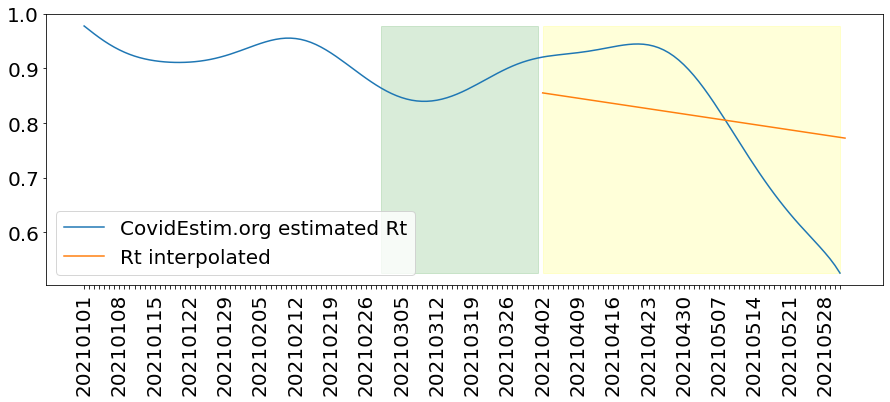

In [34]:
import numpy as np

pd_estim_data = PopulationData(data_folder+"covidestim.csv", state_long,lookback_date, end_date=str(pop_model.get_dates_to_forecast()[-1]));
days_before_Rt_interpolation = (len(pd_estim_data.filtered_data['Rt']) - pop_model.forecast_duration)

plt.figure(figsize=(15,5))
plt.plot(pd_estim_data.filtered_data['Rt'], label='CovidEstim.org estimated Rt')
plt.plot(([np.nan]*days_before_Rt_interpolation) +  list(pop_model.get_forecasted_data()['Rt']), label='Rt interpolated');

x_dates = pd_estim_data.filtered_data['date']
x_dates = [x if e%7==0 else '' for e,x in enumerate(x_dates)]   
plt.xticks(range(len(x_dates)),x_dates, rotation=90)

plt.fill_between(range((days_before_Rt_interpolation),len(x_dates)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='yellow')

plt.fill_between(range((days_before_Rt_interpolation-(pop_model.training_data.filtered_data.num_rows())),(days_before_Rt_interpolation)), 
                 min(pd_estim_data.filtered_data['Rt']), max(pd_estim_data.filtered_data['Rt']),
                alpha=0.15, color='green')
plt.legend()
# plt.grid()


In [16]:
pop_model.get_forecasted_data()['Rt']

dtype: float
Rows: 61
[0.8551855571607966, 0.8538071652170917, 0.8524287732733866, 0.8510503813296817, 0.8496719893859767, 0.8482935974422717, 0.8469152054985668, 0.8455368135548618, 0.8441584216111568, 0.8427800296674519, 0.8414016377237469, 0.840023245780042, 0.8386448538363369, 0.837266461892632, 0.8358880699489271, 0.834509678005222, 0.8331312860615171, 0.8317528941178121, 0.8303745021741071, 0.8289961102304022, 0.8276177182866972, 0.8262393263429922, 0.8248609343992872, 0.8234825424555823, 0.8221041505118774, 0.8207257585681723, 0.8193473666244674, 0.8179689746807625, 0.8165905827370574, 0.8152121907933525, 0.8138337988496475, 0.8124554069059425, 0.8110770149622376, 0.8096986230185326, 0.8083202310748276, 0.8069418391311226, 0.8055634471874177, 0.8041850552437128, 0.8028066633000077, 0.8014282713563028, 0.8000498794125979, 0.7986714874688928, 0.7972930955251879, 0.7959147035814829, 0.7945363116377779, 0.793157919694073, 0.791779527750368, 0.790401135806663, 0.789022743862958, 0.78

# save the forecasted data to a csv file

In [ ]:
import math
def roundup100th(x):
    if x<=200:
        return int(math.ceil(x / 25.0)) * 25
    else:
        return int(math.ceil(x / 100.0)) * 100

def plot_performance(new_params):
    color_list = ['k','k','k','k','k']
    fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=5, ncols=1,figsize=(15,15), sharex=True)   
    truth_data = get_truthdict_given_mid_end('20210101', '20210601')
    print(pd_truthful.start_date, ' to ', pd_truthful.end_date)
    print('cyan = forecasts after being trained on that interval')
    print('violet = forecasts on validation/unseen interval')

    



    for i,(p,c) in enumerate(zip(['Rt','infections', 'symptomatic', 'severe','hosp'],color_list)):
        if p != 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = c,ls=':' )")
        if p == 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = 'g',ls=':' )")
        
        if p != 'Rt':
            eval('ax'+str(i+1) + ".plot( truth_data[p], color = c,ls=':' )")
                            
        for pd in pd_list_train:
            pd.training_mode = False
            fc_data = pd.get_forecasted_data(new_params) 
            print(pd.start_date, pd.end_date, 'start and end date')
#             print(pd.start_date,pd.end_date,'start end date')
#             print(truth_data,'truth data')
#             print(fc_data[-10:],'fc_data data')
#             return
    #         '-', '--', '-.', ':',
            start_idx = list(truth_data['date']).index(int(fc_data['date'][0]))
            end_idx = start_idx + len(fc_data['date']) - 1
            if p != 'Rt':
                eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'c',ls = '-' )")
            else:
                eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'k',ls = ':' )")

        #         for pd in pd_list_val:
#         for pd in pd_list_train:
#             pd.training_mode = False
#             end_date_original = pd.end_date
#             pd.end_date = str((datetime.datetime.strptime(str(end_date_original),'%Y%m%d') + datetime.timedelta(days = forecast_duration)).strftime('%Y%m%d'))
#             fc_data = pd.get_forecasted_data(new_params) 
#     #         '-', '--', '-.', ':',
#             start_idx = list(truth_data['date']).index(int(fc_data['date'][0]))
#             end_idx = start_idx + len(fc_data['date']) - 1
#             if p != 'Rt':
#                 eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'm',ls = ':' )")
#             else:
#                 eval('ax'+str(i+1) + ".plot( list(range(start_idx,end_idx+1)),fc_data[p], color = 'k',ls = ':' )")
            
#             pd.end_date = end_date_original
#         eval('ax'+str(i+1) + '.set_title(p)')
#         eval('ax'+str(i+1) + '.grid()')
#     # current_labels = ax4.get_xticklabels()

    #     eval('ax'+str(i+1) + ".set_xticklabels( [str(d) for d in list(truth_data['date']) ] )" )
    current_labels = ax4.get_xticks();
    date_labels = [truth_data['date'][int(jj)] if jj<len(truth_data['date']) else '' for jj in list(current_labels[1:-1]) ]

    ax4.set_xticklabels(['']+ date_labels)
    
    maxy = max(int(np.max(np.array(truth_data['hosp']))),int(np.max(np.array(fc_data['hosp']))))
    ax5.set_yticks(np.arange(0, maxy, step=roundup100th(maxy/6)))
    ax5.figure.savefig(results_folder+state_short+'_hosp_forecast_trained_on_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
# train_params = {'T_serial':5.8,'prob_sympt':0.536,'prob_severe':0.1,'prob_hosp':0.55,'prob_soujourn_inf_alpha':3.41, 'prob_soujourn_inf_beta':0.605,'prob_soujourn_symp_alpha':1.62, 'prob_soujourn_symp_beta':0.218}
# train_params = {'T_serial':5.8,'prob_sympt':0.82,'prob_severe':0.2,'prob_hosp':0.25,'prob_soujourn_inf_alpha':3.41, 'prob_soujourn_inf_beta':0.605,'prob_soujourn_symp_alpha':1.62, 'prob_soujourn_symp_beta':0.218}


train_params = {'T_serial':5.8,'prob_sympt_s':sigmoid_inv(0.82),'prob_severe_s':sigmoid_inv(0.2),'prob_hosp_s':sigmoid_inv(0.25),
                'prob_soujourn_inf_alpha_s':softplus_inv(3.41), 'prob_soujourn_inf_beta_s':softplus_inv(0.605),
                'prob_soujourn_symp_alpha_s':softplus_inv(1.62), 'prob_soujourn_symp_beta_s':softplus_inv(0.218)}

print(train_params)
plot_performance(train_params)
plt.xticks(rotation=90)
plt.show()

####PICKLE RELOAD NEW PARAMS IN 
if RELOADING_RESULTS:
    import pickle
    filename = results_folder+ state_short + '_population_params_trained_on_'+str(training_end_date)+'_'+str(training_end_dates[0])

    with open(filename+'.pickle', 'rb') as handle:
        new_params = pickle.load(handle)


print(new_params)
plot_performance(new_params)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# pd_list_train[0].end_date = '20210501'
pd_list_train[0].end_date = '20210801'
pd_list_train[0].get_forecasted_data(new_params, save_admissions=True) 

In [ ]:
if not RELOADING_RESULTS: # save newly learned results
    import pickle
    filename = results_folder+state_short + '_population_params_trained_on_'+str(training_end_date)+'_'+str(training_end_dates[0])
    with open(filename+'.pickle', 'wb') as handle:
        pickle.dump(new_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(filename+'.pickle', 'rb') as handle:
        b = pickle.load(handle)

    print (new_params == b)
    print(new_params)

In [ ]:
## TODO consider plotting the prior distrobutions and consider plotting posterior distribution

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

prior_params_ab = {'prob_sympt_s':[5.5,2],'prob_severe_s':[2,5],'prob_hosp_s':[2,4]}

        
for k,v in prior_params_ab.items():
    a = v[0]
    b = v[1]
    mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
#     print(mean,'*mean value given a,b*', a,b)
#     print(var,'*var value given a,b*', a,b)
    print(sigmoid(new_params[k]), 'optimized param', k)

    x = np.linspace(0,1,1000)
    pdf_vals = beta.pdf(x, a, b)
    imax = np.argmax(pdf_vals)
    print(x[imax],'*mode value given a,b*', a,b)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label=k+' beta prior')
#     plt.vlines(sigmoid(new_params[k]),np.min(pdf_vals),beta.pdf(sigmoid(new_params[k]), a, b), label='optimized '+ k)

#     plt.legend(loc='best', frameon=False)

    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ k+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    

In [ ]:
import numpy as np
from scipy.stats import gamma
# import matplotlib.pyplot as plt
import math
qfn = lambda a,b,c: [(-b + math.sqrt(b**2 - (4*a*c) )) / (2 * a),(-b - math.sqrt(b**2 - (4*a*c) )) / (2 * a)]

            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
soj_new_params = [softplus(new_params['prob_soujourn_inf_alpha_s']),softplus(new_params['prob_soujourn_inf_beta_s']),
                  softplus(new_params['prob_soujourn_symp_alpha_s']),softplus(new_params['prob_soujourn_symp_beta_s'])
                 ]
soj_param_names = ['prob_soujourn_inf_alpha_s','prob_soujourn_inf_beta_s','prob_soujourn_symp_alpha_s','prob_soujourn_symp_beta_s']
for i,mode_value in enumerate([3.41,0.605,1.62,0.218]):
# for i,mode_value in enumerate([3.41,0.605,1.62,0.23]):
    betas = qfn(4,-mode_value,-1)
    beta = max(betas)

    a = 4*beta**2

    print(a,beta, 'a,b')
    print(soj_new_params[i], '= optimized', soj_param_names[i])

#     fig, ax = plt.subplots(1, 1)
    x = np.linspace(0,15, 1000)
    rv = gamma(a,scale=1/beta)
    pdf_vals = rv.pdf(x)
    imax = np.argmax(pdf_vals)
    
    plt.plot(x, pdf_vals, 'k-', lw=5, label='gamma prior')
    print('mode value = ' + str(x[imax]) + ' vs opt ' + str(soj_new_params[i]))
#     plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')

#     plt.legend(loc='best', frameon=False)
#     plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
    plt.grid()
    plt.savefig(results_folder+state_short+'_prior_'+ soj_param_names[i]+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
    plt.show()
    
    print('------')

In [ ]:
import os

import numpy as np


from scipy.special import gamma as gamma_fcn
from autograd_gamma import gammainc

from scipy.special import expit as sigmoid
from scipy.special import logit as sigmoid_inv
softplus = lambda x: np.log(1+np.exp(x))

softplus_inv = lambda x: np.log(np.exp(x) -1)
def log_gamma_pdf(x,alpha,beta):
    return alpha*np.log(beta) + (alpha-1)*np.log(x) - (beta*x) - np.log(gamma_fcn(alpha))

def gamma_at_x(params,x):
    if x==0:
        return 0.0 
    if x==1:
        return cdf_at_x(params,x)
    elif x>1:
        return cdf_at_x(params,x) - cdf_at_x(params,x-1)

def cdf_at_x(params,x):
    return (gammainc(params['alpha'],params['beta']*x))



In [ ]:
            # self.params['prob_soujourn_inf_alpha']= 3.41
    # self.params['prob_soujourn_inf_beta']= 0.605
    # self.params['prob_soujourn_symp_alpha']= 1.62
    # self.params['prob_soujourn_symp_beta']= 0.218
from matplotlib.pyplot import stem
########## INF SOJOURN
a = softplus(new_params['prob_soujourn_inf_alpha_s'])
beta = softplus(new_params['prob_soujourn_inf_beta_s'])
x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(3.41,scale=1/.605)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, label='inf soj posterior')
# plt.plot(x, rv0.pdf(x), 'k-', lw=5, label='inf soj prior pdf')

stem(x, [gamma_at_x({'alpha':3.41,'beta':.605},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
# plt.bar(x,[gamma_at_x({'alpha':a,'beta':beta},val) for val in x])
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
plt.title('I-Sojourn-PMF')
plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_I-Sojourn-PMF_'+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()
        
        
########## SYMP SOJOURN
                  
                  
a = softplus(new_params['prob_soujourn_symp_alpha_s'])
beta = softplus(new_params['prob_soujourn_symp_beta_s'])

x = np.linspace(1,40, 40)
rv = gamma(a,scale=1/beta)
rv0 = gamma(1.62,scale=1/.218)

# plt.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='symp soj posterior')
# plt.plot(x, rv0.pdf(x), 'k:', lw=3, label='symp soj prior')
# plt.vlines(soj_new_params[i], ymin=0,ymax=rv.pdf(soj_new_params[i]),label='optimized param')
stem(x, [gamma_at_x({'alpha':1.62,'beta':.218},val) for val in x], linefmt='k-', markerfmt='ks', basefmt='r-', label='prior PMF')
stem(x, [gamma_at_x({'alpha':a,'beta':beta},val) for val in x], linefmt='b:', markerfmt='bo', basefmt='r-', label='MAP PMF')
plt.title('S-Sojourn-PMF')

plt.legend(loc='best', frameon=False)
# plt.title('mode value = ' + str(mode_value) + ' vs opt ' + str(soj_new_params[i]))
plt.grid()
plt.savefig(results_folder+state_short+'_MAP_'+ '_S-Sojourn-PMF_'+'_'+str(training_end_date)+'_'+str(training_end_dates[0])  +'.pdf', bbox_inches='tight')
plt.show()